# Chebyshev Spectral GCN

```
@inproceedings{defferrard_convolutional_2016,
  abstract = {In this work, we are interested in generalizing convolutional neural networks (CNNs) from low-dimensional regular grids, where image, video and speech are represented, to high-dimensional irregular domains, such as social networks, brain connectomes or words’ embedding, represented by graphs. We present a formulation of CNNs in the context of spectral graph theory, which provides the necessary mathematical background and efﬁcient numerical schemes to design fast localized convolutional ﬁlters on graphs. Importantly, the proposed technique offers the same linear computational complexity and constant learning complexity as classical CNNs, while being universal to any graph structure. Experiments on MNIST and 20NEWS demonstrate the ability of this novel deep learning system to learn local, stationary, and compositional features on graphs.},
  added-at = {2020-02-21T16:09:44.000+0100},
  author = {Defferrard, Michaël and Bresson, Xavier and Vandergheynst, Pierre},
  biburl = {https://www.bibsonomy.org/bibtex/24fab87d273c657259dccd3dae54efd88/tschumacher},
  booktitle = {Advances in neural information processing systems},
  file = {Defferrard et al - Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering.pdf:C\:\\Users\\Admin\\Documents\\Research\\_Paperbase\\Graph Embeddings\\Defferrard et al - Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering.pdf:application/pdf},
  interhash = {2c157b976309bd862a0d1d769ad7f978},
  intrahash = {4fab87d273c657259dccd3dae54efd88},
  keywords = {imported},
  language = {en},
  pages = {3844--3852},
  timestamp = {2020-02-21T16:09:44.000+0100},
  title = {Convolutional {Neural} {Networks} on {Graphs} with {Fast} {Localized} {Spectral} {Filtering}},
  year = 2016
}

```

In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
import numpy as np
import torch
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn import ChebConv
from utils.startup_data_set import *
from utils.PredictorClasses import *
from utils.CustomMetrics import *
from utils.CustomUtilities import *
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [2]:
graph = COMP4222Dataset()
g = graph[0].to(device)

## Hyperparameters

In [3]:
val_ratio = 0.1
test_ratio = 0.1
# Hyperparameters
in_feats = g.ndata["feat"].shape[1]
n_hidden = 64
out_dim = 32
filter_size = 25

## Generate Postitve Graph and Negative Graph with Spliting

In [4]:
train_g, train_pos_g, val_pos_g, test_pos_g, *_ = generate_pos_graph(g)

In [5]:
train_neg_g, val_neg_g, test_neg_g = generate_neg_graph(g)

In [6]:
train_g, train_pos_g, val_pos_g, test_pos_g = train_g.to(device), train_pos_g.to(device), val_pos_g, test_pos_g.to(device)
train_neg_g, val_neg_g, test_neg_g = train_neg_g.to(device), val_neg_g.to(device), test_neg_g.to(device)
num_nodes = g.num_nodes
num_edges = g.num_edges

## Model Training

### Model Setup

In [7]:
class ChebConvModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 filter_size):
        super(ChebConvModel, self).__init__()

        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(ChebConv(in_feats, n_hidden, filter_size))
        # output layer
        self.layers.append(ChebConv(n_hidden, out_dim, filter_size))
        
    def forward(self, g, features, lambda_max):
        h = features.float()
        for layer in self.layers:
            h = layer(g, h,lambda_max).float()
        return h

In [10]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(2*h_feats , h_feats).to(torch.float32)
        self.W2 = nn.Linear(h_feats, 1).to(torch.float32)

    # concat the source and destination node, use mlp to predict the score
    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1).to(torch.float32)

        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h.to(torch.float32)
            g.apply_edges(self.apply_edges)
            return g.edata['score']

        
chebconv_model = ChebConvModel(in_feats,n_hidden,out_dim,filter_size).to(device)
pred = MLPPredictor(32).to(device)
early_stopping = 10
lamba_max = dgl.laplacian_lambda_max(train_g)

### Training Loop

In [11]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0
ep = 101
optimizer = torch.optim.Adam(itertools.chain(chebconv_model.parameters(), pred.parameters()))

for e in range(ep):
    # forward
    h = chebconv_model(train_g, train_g.ndata['feat'].to(torch.float32),lamba_max)
    pos_score = pred(train_pos_g,h)
    neg_score = pred(train_neg_g,h)
    # update 
    
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 10 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))


    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break


Epoch: 0 	 Train loss: 0.694 	 Val loss: 0.693 	 Train AUC: 0.823 	 Val AUC: 0.804
Epoch: 10 	 Train loss: 0.489 	 Val loss: 0.497 	 Train AUC: 0.947 	 Val AUC: 0.873
Epoch: 20 	 Train loss: 0.364 	 Val loss: 0.464 	 Train AUC: 0.944 	 Val AUC: 0.873
Epoch: 30 	 Train loss: 0.331 	 Val loss: 0.45 	 Train AUC: 0.946 	 Val AUC: 0.874
Epoch: 40 	 Train loss: 0.315 	 Val loss: 0.464 	 Train AUC: 0.949 	 Val AUC: 0.874
Early Stopped at Epoch 45


In [12]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.8610770866819873


### Result Plotting

Text(0, 0.5, 'Loss')

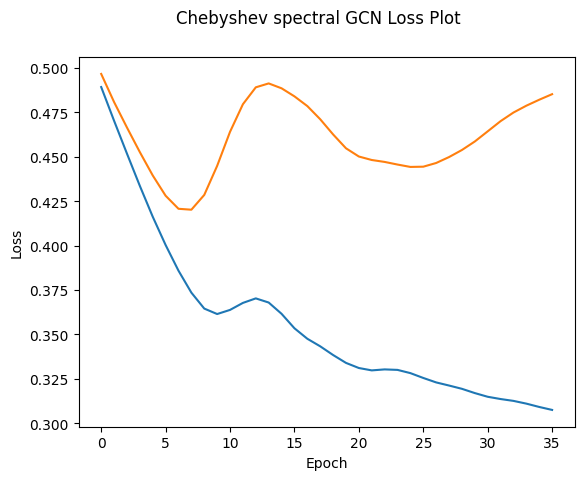

In [13]:
fig = plt.figure()
plt.plot(train_loss[10:], label='training loss')
plt.plot(val_loss[10:], label = 'validation loss')
fig.suptitle('Chebyshev spectral GCN Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'AUC')

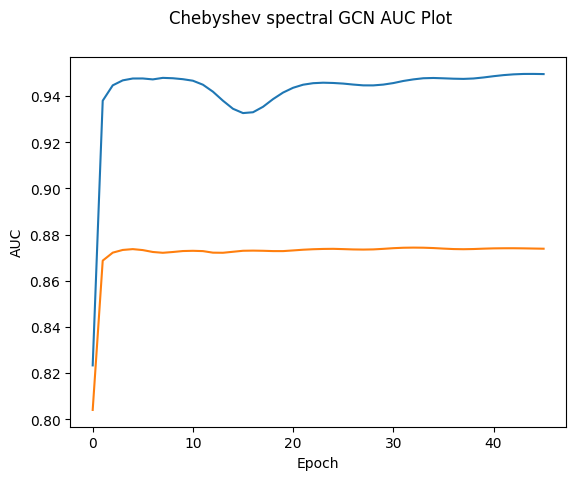

In [14]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('Chebyshev spectral GCN AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')
